# Support Vector Machines for text classification

In [3]:
# Required basic imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import re
import os
import string
import joblib
from pathlib import Path

# Imports for tokenizing and vectorizing data
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Imports for vectorized data pre-processing and classification models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

## Data preprocessing

### First, define auxiliary functions

In [4]:
def remove_emojis(text: str) -> str:
    """ Removes emojis from the given text """
    return re.sub(r"[^\w\s,!?@#áéíóúÁÉÍÓÚñÑ]", "", text)

def clear_tokens(tokens_list: list) -> None:
    """ Removes punctuation symbols from the given tokens list """
    # Traverse the list backwards to avoid logic problems with pop() and indexes order
    for i in range(len(tokens_list) - 1, -1, -1):
        if tokens_list[i] in string.punctuation:
            tokens_list.pop(i)
    return

### Tokenize with TweetTokenizer and vectorize with TF-IDF

In [5]:
def tokenize_and_vectorize(data_path: str, 
                           treat_emojis: bool=False,
                           verbose: bool=False) -> tuple:
    """ Tokenizes the messages from all the users and computes vectors from them """
    path            = Path(data_path)
    all_users_data  = []
    tokenizer       = TweetTokenizer()
    vectorizer      = TfidfVectorizer()
    users_order     = [] # List that stores the users in the order that are processed, for merging with the target

    # Iterate through the JSON data folder
    for element in path.iterdir():
        if element.is_file():
            user_id = re.findall(pattern=r"[0-9]+", string=element.name)[0]
            users_order.append(user_id)

            # Some execution verbose
            if verbose:
                print(f"Tokenizing messages from user: {user_id}")

            # Open and read the current JSON file
            with open(data_path + f'/{element.name}') as json_file:
                json_data = json.load(fp=json_file)

                if treat_emojis:
                    # Emojis must be deleted from the messages
                    messages = [ remove_emojis(str(record['message'])) for record in json_data ]

                else:
                    # Preserve emojis in the messages
                    messages = [ str(record['message']) for record in json_data ]

                # Apply the TweetTokenizer algorithm
                tokenized = [ tokenizer.tokenize(m) for m in messages ]

                # Remove punctuation symbols tokens
                for i, t in enumerate(tokenized):
                    clear_tokens(tokens_list=t)

                    # If the resulting list is empty, then remove it
                    if len(t) == 0:
                        tokenized.pop(i)
                
                # Join the tokens of a single message, since that is what expects the implementation of TF-IDF
                user_document = " ".join(tokenized[0])
                for i in range(1, len(tokenized)):
                    tokens_joined = " ".join(tokenized[i])
                    user_document += " " + tokens_joined
            
                # Merge the previous data with the current user's
                all_users_data.append(user_document)

    # Vectorize all the messages with the TF-IDF and return the data as a Pandas DataFrame
    X  = vectorizer.fit_transform(all_users_data)
    df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    return df, users_order

In [6]:
# Get the data from all users
data_path_task1                        = os.getcwd() + '/data/task1/train/subjects/'
data_path_task2                        = os.getcwd() + '/data/task2/train/subjects/'
df_vectorized_task1, users_order_task1 = tokenize_and_vectorize(data_path=data_path_task1, treat_emojis=True, verbose=False)
df_vectorized_task2, users_order_task2 = tokenize_and_vectorize(data_path=data_path_task2, treat_emojis=True, verbose=False)

# Show the first five elements of each Pandas DataFrae
print(df_vectorized_task1.head())
print(df_vectorized_task2.head())

    00  000  0000  0000000  00000000000  00000085  00000110  0000014  0000017  \
0  0.0  0.0   0.0      0.0          0.0       0.0       0.0      0.0      0.0   
1  0.0  0.0   0.0      0.0          0.0       0.0       0.0      0.0      0.0   
2  0.0  0.0   0.0      0.0          0.0       0.0       0.0      0.0      0.0   
3  0.0  0.0   0.0      0.0          0.0       0.0       0.0      0.0      0.0   
4  0.0  0.0   0.0      0.0          0.0       0.0       0.0      0.0      0.0   

   000003  ...  últimamente  últimas  último  últimos   ún  única  únicamente  \
0     0.0  ...          0.0      0.0     0.0      0.0  0.0    0.0         0.0   
1     0.0  ...          0.0      0.0     0.0      0.0  0.0    0.0         0.0   
2     0.0  ...          0.0      0.0     0.0      0.0  0.0    0.0         0.0   
3     0.0  ...          0.0      0.0     0.0      0.0  0.0    0.0         0.0   
4     0.0  ...          0.0      0.0     0.0      0.0  0.0    0.0         0.0   

   único  únicos  útiles  

### Build the supervised datasets (with the target variable)

In [7]:
# Get the data from the target variable
target_path_task1 = os.getcwd() + '/data/task1/train/gold_task1.txt'
target_path_task2 = os.getcwd() + '/data/task2/train/gold_task2.txt'

target_col_task1  = pd.read_csv(filepath_or_buffer=target_path_task1, delimiter=',').to_numpy()
users_tags_task1  = { re.findall(r"[0-9]+", target_col_task1[i][0])[0]: target_col_task1[i][1] for i in range(len(target_col_task1)) }

target_col_task2  = pd.read_csv(filepath_or_buffer=target_path_task2, delimiter=',').to_numpy()
users_tags_task2  = { re.findall(r"[0-9]+", target_col_task2[i][0])[0]: target_col_task2[i][1] for i in range(len(target_col_task2)) }

# Create copies of each dataset
df_supervised_task1 = df_vectorized_task1.copy()
df_supervised_task2 = df_vectorized_task2.copy()

# Create the target column in order and add it to the Pandas DataFrame
target_task1 = np.array([ users_tags_task1[user_id] for user_id in users_order_task1 ], np.int8)
df_supervised_task1.insert(loc=len(df_supervised_task1.columns), column='Target', value=target_task1)

target_task2 = np.array([ users_tags_task2[user_id] for user_id in users_order_task2 ])
df_supervised_task2.insert(loc=len(df_supervised_task2.columns), column='Target', value=target_task2)

# Show the first five rows of each Pandas DataFrame
print(df_supervised_task1.head())
print(df_supervised_task2.head())

    00  000  0000  0000000  00000000000  00000085  00000110  0000014  0000017  \
0  0.0  0.0   0.0      0.0          0.0       0.0       0.0      0.0      0.0   
1  0.0  0.0   0.0      0.0          0.0       0.0       0.0      0.0      0.0   
2  0.0  0.0   0.0      0.0          0.0       0.0       0.0      0.0      0.0   
3  0.0  0.0   0.0      0.0          0.0       0.0       0.0      0.0      0.0   
4  0.0  0.0   0.0      0.0          0.0       0.0       0.0      0.0      0.0   

   000003  ...  últimas  último  últimos   ún  única  únicamente  único  \
0     0.0  ...      0.0     0.0      0.0  0.0    0.0         0.0    0.0   
1     0.0  ...      0.0     0.0      0.0  0.0    0.0         0.0    0.0   
2     0.0  ...      0.0     0.0      0.0  0.0    0.0         0.0    0.0   
3     0.0  ...      0.0     0.0      0.0  0.0    0.0         0.0    0.0   
4     0.0  ...      0.0     0.0      0.0  0.0    0.0         0.0    0.0   

   únicos  útiles  Target  
0     0.0     0.0       0  
1     

## Training the baseline model - Task 1

### Base model - SVM

In [8]:
# Perform the train-test split
X, y = df_supervised_task1.drop(columns=['Target'], axis=1), df_supervised_task1['Target'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y, 
                                                    shuffle=True)

# Train the SVM
clf_svm = LinearSVC()
clf_svm.fit(X_train, y_train)

# Evaluate with test
y_pred = clf_svm.predict(X_test)
acc    = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f"SVM accuracy: {round(acc, 2)}")
print(classification_report(y_test, y_pred))

SVM accuracy: 0.7
              precision    recall  f1-score   support

           0       0.68      0.78      0.73        36
           1       0.72      0.62      0.67        34

    accuracy                           0.70        70
   macro avg       0.70      0.70      0.70        70
weighted avg       0.70      0.70      0.70        70



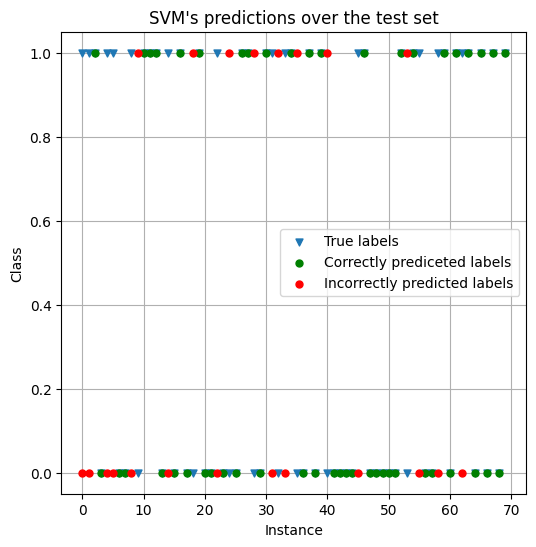

In [9]:
# Plot the predictions over the test set
y_correct_indexes, y_incorrect_indexes = np.where(y_pred == y_test), np.where(y_pred != y_test)
y_correct, y_incorrect = y_pred[y_correct_indexes], y_pred[y_incorrect_indexes]

plt.figure(figsize=(6, 6))
plt.title("SVM's predictions over the test set")
plt.scatter(range(len(y_test)), y_test, s=25.0, marker='v', label='True labels', zorder=2)
plt.scatter(y_correct_indexes, y_correct, s=25.0, label='Correctly prediceted labels', zorder=2, c='green')
plt.scatter(y_incorrect_indexes, y_incorrect, s=25.0, label='Incorrectly predicted labels', zorder=2, c='red')
plt.xlabel("Instance")
plt.ylabel("Class")
plt.grid(True)
plt.legend()
plt.show()

### Hyper-parameter search

In [10]:
param_grid_svm = {
    'C': [ 0.1, 1, 2, 3, 7 ],
    'gamma': [ 'scale', 0.01, 0.001, 0.0001 ],
    'kernel': [ 'linear', 'rbf' ]
}

svc      = SVC()
grid_svm = GridSearchCV(svc, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1, verbose=True)
grid_svm.fit(X_train, y_train)

# CV results
print("Best hyper-parameters found:")
print(grid_svm.best_params_)
print("\nBest cross validation score:")
print(grid_svm.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best hyper-parameters found:
{'C': 3, 'gamma': 'scale', 'kernel': 'rbf'}

Best cross validation score:
0.6785714285714286


In [11]:
# Evaluate with test
clf_svm = grid_svm.best_estimator_
y_pred  = clf_svm.predict(X_test)
acc     = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f"SVM accuracy: {round(acc, 2)}")
print(classification_report(y_test, y_pred))

SVM accuracy: 0.73
              precision    recall  f1-score   support

           0       0.71      0.81      0.75        36
           1       0.76      0.65      0.70        34

    accuracy                           0.73        70
   macro avg       0.73      0.73      0.73        70
weighted avg       0.73      0.73      0.73        70



### Base model - Random Forest

In [12]:
# Train the RF
clf_rf = RandomForestClassifier(n_estimators=256,
                                criterion='entropy',
                                max_depth=None,
                                random_state=42,
                                n_jobs=-1)
clf_rf.fit(X_train, y_train)

# Evaluate with test
y_pred = clf_rf.predict(X_test)
acc    = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f"RF accuracy: {round(acc, 2)}")
print(classification_report(y_test, y_pred))

RF accuracy: 0.63
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        36
           1       0.62      0.62      0.62        34

    accuracy                           0.63        70
   macro avg       0.63      0.63      0.63        70
weighted avg       0.63      0.63      0.63        70



### Hyper-parameter search

In [13]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],         # Number of decision trees
    'max_depth': [None, 10, 20, 30],         # Max depth of each tree
    'min_samples_split': [2, 5, 10],         # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 4],           # Minimum number of samples to be a leaf node
    'bootstrap': [True, False]               # Use bootstrapping
}

# Define the Random Forest classifier
clf_rf  = RandomForestClassifier(random_state=42)

grid_rf = GridSearchCV(
    estimator=clf_rf,
    param_grid=param_grid_rf,
    cv=5,  # 5-fold cross validation
    scoring='accuracy',
    n_jobs=-1,  # use all available cores in the CPU (multithreading)
    verbose=1
)

grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

### Evaluation with test

In [14]:
# Evaluate with test
clf_rf    = grid_rf.best_estimator_
y_pred    = clf_rf.predict(X_test)
acc       = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f"RF accuracy: {round(acc, 2)}")
print(classification_report(y_test, y_pred))

RF accuracy: 0.71
              precision    recall  f1-score   support

           0       0.71      0.75      0.73        36
           1       0.72      0.68      0.70        34

    accuracy                           0.71        70
   macro avg       0.71      0.71      0.71        70
weighted avg       0.71      0.71      0.71        70



## Training the final model - Task 1

In [15]:
# Train with all the available data
clf_final = SVC(**grid_svm.best_params_)
clf_final.fit(X=X, y=y)

# Evaluate the final model (CAUTION: THIS METRICS ARE OPTIMISTIC!!! DO NOT USE THEM TO VALIDATE THE MODEL'S GENERALIZATION)
y_pred = clf_final.predict(X)
acc    = accuracy_score(y_true=y, y_pred=y_pred)
print(f"Final SVM accuracy: {round(acc, 2)}")
print(classification_report(y_true=y, y_pred=y_pred))

# Store the final model in disk
joblib.dump(value=clf_final, filename=f'{os.getcwd()}/trained_models/SVM_task1.joblib')

Final SVM accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       178
           1       1.00      1.00      1.00       172

    accuracy                           1.00       350
   macro avg       1.00      1.00      1.00       350
weighted avg       1.00      1.00      1.00       350



['/home/pablo/Escritorio/Universidad/NLP/NLP-MENTALRISK-IBERLEF-2025/trained_models/SVM_task1.joblib']

## Training the baseline model - Task 2

### Base model - SVM

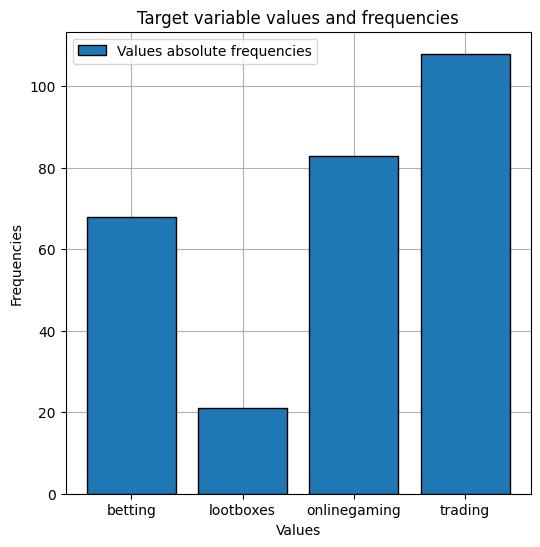

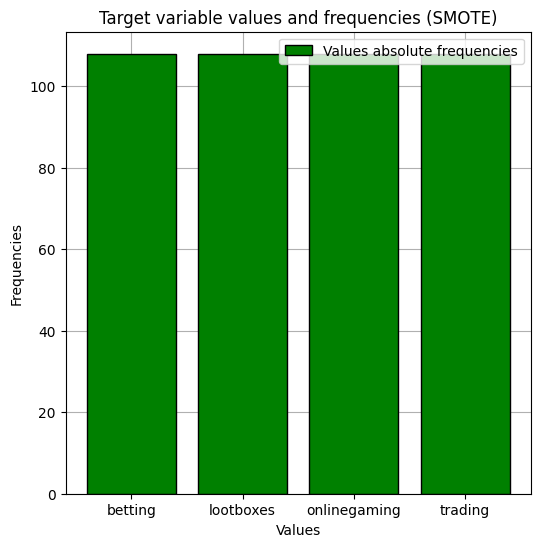

In [16]:
# Perform the train-test split
X, y = df_supervised_task2.drop(columns=['Target'], axis=1), df_supervised_task2['Target'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y, 
                                                    shuffle=True)

# Get the unique values of the target variable and its frequencies
unique_values, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(6, 6))
plt.title("Target variable values and frequencies")
plt.bar(unique_values, counts, edgecolor='black', label='Values absolute frequencies', zorder=2)
plt.xlabel("Values")
plt.ylabel("Frequencies")
plt.grid(True)
plt.legend()
plt.show()

# Apply oversampling with SMOTE into the training set (ONLY!!! TO AVOID DATA LEAKAGE)
smote = SMOTE(random_state=42, k_neighbors=5)
X_train, y_train = smote.fit_resample(X=X_train, y=y_train)

# Get the unique values of the target variable and its frequencies after resampling
unique_values, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(6, 6))
plt.title("Target variable values and frequencies (SMOTE)")
plt.bar(unique_values, counts, edgecolor='black', label='Values absolute frequencies', zorder=2, color='green')
plt.xlabel("Values")
plt.ylabel("Frequencies")
plt.grid(True)
plt.legend()
plt.show()

In [17]:
# Train the SVM
clf_svm = LinearSVC()
clf_svm.fit(X_train, y_train)

# Evaluate with test
y_pred = clf_svm.predict(X_test)
acc    = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f"SVM accuracy: {round(acc, 2)}")
print(classification_report(y_test, y_pred))

SVM accuracy: 0.96
              precision    recall  f1-score   support

     betting       1.00      1.00      1.00        17
   lootboxes       1.00      0.40      0.57         5
onlinegaming       0.88      1.00      0.93        21
     trading       1.00      1.00      1.00        27

    accuracy                           0.96        70
   macro avg       0.97      0.85      0.88        70
weighted avg       0.96      0.96      0.95        70



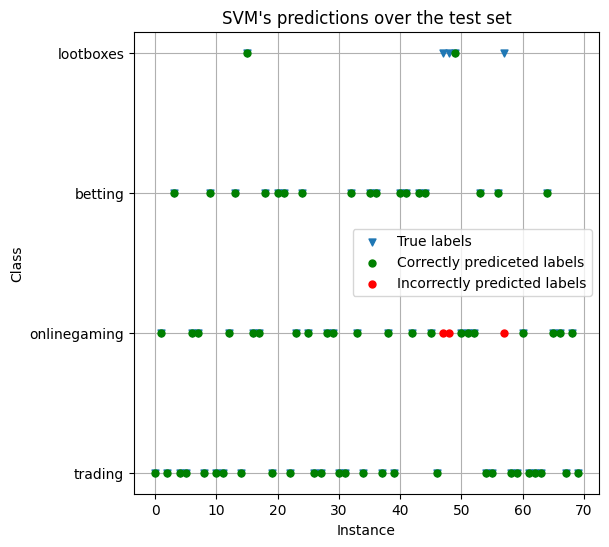

In [18]:
# Plot the predictions over the test set
y_correct_indexes, y_incorrect_indexes = np.where(y_pred == y_test), np.where(y_pred != y_test)
y_correct, y_incorrect = y_pred[y_correct_indexes], y_pred[y_incorrect_indexes]

plt.figure(figsize=(6, 6))
plt.title("SVM's predictions over the test set")
plt.scatter(range(len(y_test)), y_test, s=25.0, marker='v', label='True labels', zorder=2)
plt.scatter(y_correct_indexes, y_correct, s=25.0, label='Correctly prediceted labels', zorder=2, c='green')
plt.scatter(y_incorrect_indexes, y_incorrect, s=25.0, label='Incorrectly predicted labels', zorder=2, c='red')
plt.xlabel("Instance")
plt.ylabel("Class")
plt.grid(True)
plt.legend()
plt.show()

### Hyper-parameter search

In [19]:
param_grid_svm = {
    'C': [ 0.1, 1, 2, 3, 7 ],
    'gamma': [ 'scale', 0.01, 0.001, 0.0001 ],
    'kernel': [ 'linear', 'rbf' ]
}

svc      = SVC()
grid_svm = GridSearchCV(svc, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1, verbose=True)
grid_svm.fit(X_train, y_train)

# CV results
print("Best hyper-parameters found:")
print(grid_svm.best_params_)
print("\nBest cross validation score:")
print(grid_svm.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best hyper-parameters found:
{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}

Best cross validation score:
0.9953755680299384


### Evaluation with test

In [20]:
# Evaluate with test
clf_svm    = grid_svm.best_estimator_
y_pred     = clf_svm.predict(X_test)
acc       = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f"RF accuracy: {round(acc, 2)}")
print(classification_report(y_test, y_pred))

RF accuracy: 0.96
              precision    recall  f1-score   support

     betting       1.00      1.00      1.00        17
   lootboxes       1.00      0.40      0.57         5
onlinegaming       0.88      1.00      0.93        21
     trading       1.00      1.00      1.00        27

    accuracy                           0.96        70
   macro avg       0.97      0.85      0.88        70
weighted avg       0.96      0.96      0.95        70



### Base model - Random Forest

In [21]:
# Train the RF
clf_rf = RandomForestClassifier(n_estimators=256,
                                criterion='entropy',
                                max_depth=None,
                                random_state=42,
                                n_jobs=-1)
clf_rf.fit(X_train, y_train)

# Evaluate with test
y_pred = clf_rf.predict(X_test)
acc    = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f"RF accuracy: {round(acc, 2)}")
print(classification_report(y_test, y_pred))

RF accuracy: 0.99
              precision    recall  f1-score   support

     betting       1.00      1.00      1.00        17
   lootboxes       1.00      0.80      0.89         5
onlinegaming       0.95      1.00      0.98        21
     trading       1.00      1.00      1.00        27

    accuracy                           0.99        70
   macro avg       0.99      0.95      0.97        70
weighted avg       0.99      0.99      0.99        70



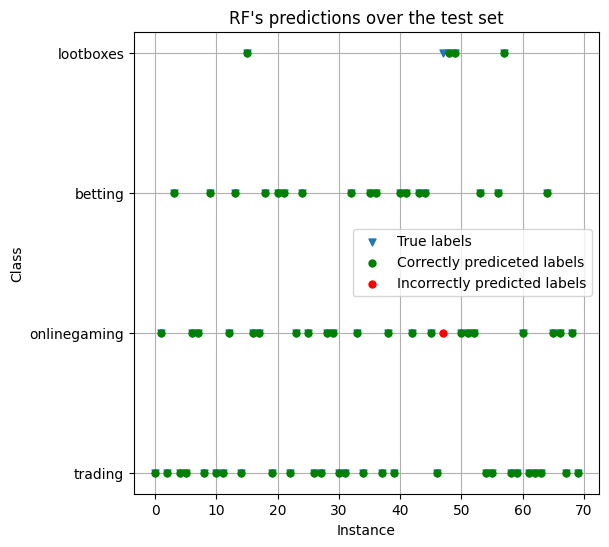

In [22]:
# Plot the predictions over the test set
y_correct_indexes, y_incorrect_indexes = np.where(y_pred == y_test), np.where(y_pred != y_test)
y_correct, y_incorrect = y_pred[y_correct_indexes], y_pred[y_incorrect_indexes]

plt.figure(figsize=(6, 6))
plt.title("RF's predictions over the test set")
plt.scatter(range(len(y_test)), y_test, s=25.0, marker='v', label='True labels', zorder=2)
plt.scatter(y_correct_indexes, y_correct, s=25.0, label='Correctly prediceted labels', zorder=2, c='green')
plt.scatter(y_incorrect_indexes, y_incorrect, s=25.0, label='Incorrectly predicted labels', zorder=2, c='red')
plt.xlabel("Instance")
plt.ylabel("Class")
plt.grid(True)
plt.legend()
plt.show()

### Hyper-parameter search

In [23]:
param_grid_rf = {
    'n_estimators': [100, 200],         # Number of decision trees
    'max_depth': [None, 10, 20],        # Max depth of each tree
    'min_samples_split': [2, 5],        # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2],         # Minimum number of samples to be a leaf node
    'bootstrap': [True, False]          # Use bootstrapping
}

# Define the Random Forest classifier
clf_rf  = RandomForestClassifier(random_state=42)

grid_rf = GridSearchCV(
    estimator=clf_rf,
    param_grid=param_grid_rf,
    cv=3,  # 3-fold cross validation
    scoring='accuracy',
    n_jobs=-1,  # use all available cores in the CPU (multithreading)
    verbose=1
)

grid_rf.fit(X_train, y_train)

# CV results
print("Best hyper-parameters found:")
print(grid_rf.best_params_)
print("\nBest cross validation score:")
print(grid_rf.best_score_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best hyper-parameters found:
{'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

Best cross validation score:
0.9976851851851851


### Evaluation with test

In [24]:
# Evaluate with test
clf_rf = grid_rf.best_estimator_
y_pred = clf_rf.predict(X_test)
acc    = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f"RF accuracy: {round(acc, 2)}")
print(classification_report(y_test, y_pred))

RF accuracy: 0.97
              precision    recall  f1-score   support

     betting       1.00      1.00      1.00        17
   lootboxes       1.00      0.60      0.75         5
onlinegaming       0.91      1.00      0.95        21
     trading       1.00      1.00      1.00        27

    accuracy                           0.97        70
   macro avg       0.98      0.90      0.93        70
weighted avg       0.97      0.97      0.97        70



## Training the final model - Task 2

In [25]:
# Train with all the available data
clf_final = RandomForestClassifier(**grid_rf.best_params_)
clf_final.fit(X=X, y=y)

# Evaluate the final model (CAUTION: THIS METRICS ARE OPTIMISTIC!!! DO NOT USE THEM TO VALIDATE THE MODEL'S GENERALIZATION)
y_pred = clf_final.predict(X)
acc    = accuracy_score(y_true=y, y_pred=y_pred)
print(f"Final RF accuracy: {round(acc, 2)}")
print(classification_report(y_true=y, y_pred=y_pred))

# Store the final model in disk
joblib.dump(value=clf_final, filename=f'{os.getcwd()}/trained_models/RF_task2.joblib')

Final RF accuracy: 0.99
              precision    recall  f1-score   support

     betting       1.00      1.00      1.00        85
   lootboxes       1.00      0.85      0.92        26
onlinegaming       0.96      1.00      0.98       104
     trading       1.00      1.00      1.00       135

    accuracy                           0.99       350
   macro avg       0.99      0.96      0.97       350
weighted avg       0.99      0.99      0.99       350



['/home/pablo/Escritorio/Universidad/NLP/NLP-MENTALRISK-IBERLEF-2025/trained_models/RF_task2.joblib']